In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import gc
warnings.filterwarnings('ignore')
#import shap

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
train = pd.read_csv('dataset-0510/train.csv')
test  = pd.read_csv('dataset-0510/test.csv')
gc.collect()

227

In [2]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [30]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [32]:
def lgb_model(split_num, train, test, features, stratified = False):
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits=split_num, shuffle=True,random_state=42)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000, 'max_depth' : 5, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9
    }
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=200, early_stopping_rounds= 1000)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    display_importances(feature_importance_df)
    return predictions


In [10]:
features = [i for i in train.columns if i not in ['building_id', 'total_price']] 

Training until validation scores don't improve for 1000 rounds.
[200]	training's rmse: 0.417043	valid_1's rmse: 0.415737
[400]	training's rmse: 0.292039	valid_1's rmse: 0.29695
[600]	training's rmse: 0.259767	valid_1's rmse: 0.268423
[800]	training's rmse: 0.243877	valid_1's rmse: 0.255236
[1000]	training's rmse: 0.233307	valid_1's rmse: 0.246941
[1200]	training's rmse: 0.22539	valid_1's rmse: 0.240926
[1400]	training's rmse: 0.219253	valid_1's rmse: 0.236717
[1600]	training's rmse: 0.214214	valid_1's rmse: 0.233431
[1800]	training's rmse: 0.209696	valid_1's rmse: 0.23065
[2000]	training's rmse: 0.205494	valid_1's rmse: 0.228121
[2200]	training's rmse: 0.201662	valid_1's rmse: 0.225838
[2400]	training's rmse: 0.198165	valid_1's rmse: 0.223824
[2600]	training's rmse: 0.195071	valid_1's rmse: 0.222195
[2800]	training's rmse: 0.192018	valid_1's rmse: 0.220644
[3000]	training's rmse: 0.189214	valid_1's rmse: 0.219235
[3200]	training's rmse: 0.186539	valid_1's rmse: 0.21787
[3400]	training'

[7200]	training's rmse: 0.149604	valid_1's rmse: 0.212499
[7400]	training's rmse: 0.148207	valid_1's rmse: 0.212128
[7600]	training's rmse: 0.146889	valid_1's rmse: 0.211802
[7800]	training's rmse: 0.145569	valid_1's rmse: 0.211465
[8000]	training's rmse: 0.144334	valid_1's rmse: 0.211174
[8200]	training's rmse: 0.143102	valid_1's rmse: 0.210894
[8400]	training's rmse: 0.141847	valid_1's rmse: 0.210614
[8600]	training's rmse: 0.140673	valid_1's rmse: 0.210358
[8800]	training's rmse: 0.139451	valid_1's rmse: 0.210064
[9000]	training's rmse: 0.138227	valid_1's rmse: 0.209774
[9200]	training's rmse: 0.137144	valid_1's rmse: 0.209562
[9400]	training's rmse: 0.136016	valid_1's rmse: 0.209305
[9600]	training's rmse: 0.134938	valid_1's rmse: 0.209084
[9800]	training's rmse: 0.133896	valid_1's rmse: 0.208921
[10000]	training's rmse: 0.132813	valid_1's rmse: 0.208725
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.132813	valid_1's rmse: 0.208725
Training until validat

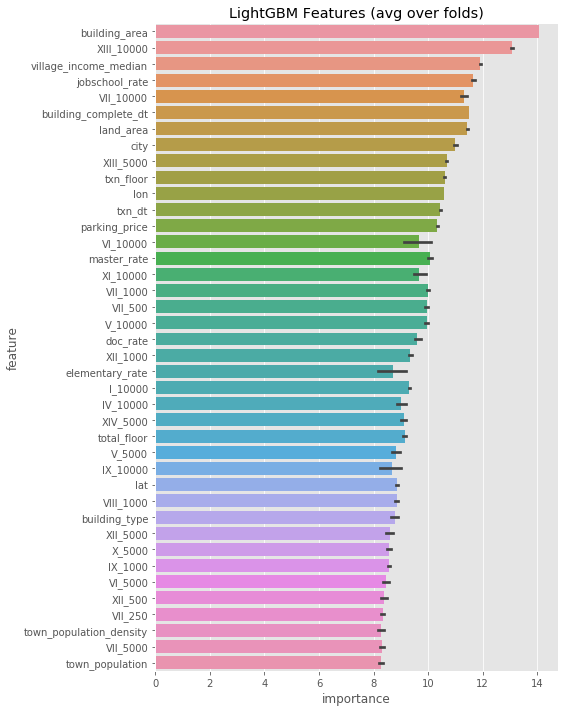

In [33]:
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)

In [34]:
Submission(test['building_id'], prediction)

In [ ]:
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)